## Task 1: Consumer-Level Flexibility Models

#### Imports

In [82]:
import json
from pathlib import Path
from dataclasses import dataclass, field
from typing import Dict, List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gurobipy as gp
from gurobipy import GRB

#### Data

In [83]:
DATA_DIR = Path("data/question_1b")

#### Helpers

In [84]:
def load_inputs(data_dir=DATA_DIR):
    with open(data_dir / "appliance_params.json") as f:
        appliance_params = json.load(f)
    with open(data_dir / "bus_params.json") as f:
        bus_params = json.load(f)[0]
    with open(data_dir / "consumer_params.json") as f:
        consumer_params = json.load(f)[0]
    with open(data_dir / "DER_production.json") as f:
        der_prod = json.load(f)[0]
    with open(data_dir / "usage_preference.json") as f:
        usage_pref = json.load(f)[0]
    return appliance_params, bus_params, consumer_params, der_prod, usage_pref

def prepare_base_inputs(appliance_params, bus_params, der_prod, usage_pref):
    T = len(bus_params["energy_price_DKK_per_kWh"])
    price = np.array(bus_params["energy_price_DKK_per_kWh"])
    imp_tariff = np.full(T, bus_params["import_tariff_DKK/kWh"])
    exp_tariff = np.full(T, bus_params["export_tariff_DKK/kWh"])

    pv_power = next(d["max_power_kW"] for d in appliance_params["DER"] if d["DER_type"] == "PV")
    pv_profile = np.array(der_prod["hourly_profile_ratio"])
    P_pv = pv_power * pv_profile
    
    l_max_hour = next(l["max_load_kWh_per_hour"] for l in appliance_params["load"])
    
    # MODIFIED for b): Calculate L_ref by multiplying the hourly ratio by the max hourly load
    load_prefs = usage_pref["load_preferences"][0]
    hourly_ratios = np.array(load_prefs["hourly_profile_ratio"])
    L_ref = hourly_ratios * l_max_hour
    
    return dict(T=T, price=price, imp_tariff=imp_tariff, exp_tariff=exp_tariff,
                P_pv=P_pv, l_max_hour=l_max_hour, L_ref=L_ref)

def make_scenarios(base):
    scenarios = {}
    # Base
    scenarios["Base"] = dict(price=base["price"], imp=base["imp_tariff"], exp=base["exp_tariff"])
    # Constant price
    scenarios["Const price"] = dict(price=np.full(base["T"], base["price"].mean()),
                                    imp=base["imp_tariff"], exp=base["exp_tariff"])
    # Net metering
    scenarios["Net metering"] = dict(price=base["price"], imp=np.zeros(base["T"]), exp=np.zeros(base["T"]))
    # No profitable export
    scenarios["No export"] = dict(price=base["price"], imp=base["imp_tariff"],
                                  exp=base["price"]+0.01)
    # Evening spike
    spike = base["price"].copy()
    spike[18:22] *= 2.0
    scenarios["Spike"] = dict(price=spike, imp=base["imp_tariff"], exp=base["exp_tariff"])
    return scenarios


### Linear Program Scaffold

In [85]:
import gurobipy as gp
from gurobipy import GRB


class InputData:
    def __init__(self, VARIABLES, objective_coeff, constraints_coeff, constraints_rhs, constraints_sense):
        self.VARIABLES = VARIABLES
        self.objective_coeff = objective_coeff
        self.constraints_coeff = constraints_coeff
        self.constraints_rhs = constraints_rhs
        self.constraints_sense = constraints_sense

class LP_OptimizationProblem:

    def __init__(self, input_data: InputData): 
        self.data = input_data 
        self.results = type("Expando", (), {})()  # simple dummy expando
        self._build_model() 
    
    def _build_variables(self):
        self.variables = {v: self.model.addVar(lb=0, name=v) for v in self.data.VARIABLES}
    
    def _build_constraints(self):
        self.constraints = []
        for i in range(len(self.data.constraints_rhs)):
            lhs = gp.quicksum(self.data.constraints_coeff[v][i] * self.variables[v] for v in self.data.VARIABLES)
            constr = self.model.addLConstr(lhs,
                                           self.data.constraints_sense[i],
                                           self.data.constraints_rhs[i],
                                           name=f"constr[{i}]")
            self.constraints.append(constr)

    def _build_objective_function(self):
        objective = gp.quicksum(self.data.objective_coeff[v] * self.variables[v] for v in self.data.VARIABLES)
        self.model.setObjective(objective, GRB.MINIMIZE)

    def _build_model(self):
        self.model = gp.Model(name='Consumer Flexibility')
        self._build_variables()
        self._build_objective_function()
        self._build_constraints()
        self.model.update()
    
    def _save_results(self):
        self.results.objective_value = self.model.ObjVal
        self.results.variables = {v: self.variables[v].X for v in self.data.VARIABLES}
        self.results.duals = {f"constr[{i}]": self.constraints[i].Pi for i in range(len(self.constraints))}

    def run(self):
        self.model.optimize()
        if self.model.status == GRB.OPTIMAL:
            self._save_results()
        else:
            print(f"optimization of {self.model.ModelName} was not successful")
    
    def display_results(self):
        print("\n-------------------   RESULTS  -------------------")
        print("Optimal objective value:", self.results.objective_value)
        print("Optimal variable values:", self.results.variables)
        print("Optimal dual values:", self.results.duals)

### LP Input Function 1a)


In [86]:
def build_input_data(base, scenario):
    T = base["T"]
    price = scenario["price"]   # hourly prices
    imp   = scenario["imp"]     # import tariffs
    exp   = scenario["exp"]     # export tariffs
    P_pv  = base["P_pv"]        # PV availability
    L_min = base["L_min"]       # minimum daily consumption
    l_max_hour = base["l_max_hour"]  # max load per hour

    # Variables: l_t, p_t, e_t, s_t, c_t for each hour
    VARIABLES = []
    for t in range(T):
        VARIABLES += [f"l[{t}]", f"p[{t}]", f"e[{t}]", f"s[{t}]", f"c[{t}]"]

    # Objective coefficients
    objective_coeff = {v: 0 for v in VARIABLES}
    for t in range(T):
        # imports cost π+τ_imp
        objective_coeff[f"e[{t}]"] = price[t] + imp[t]
        # exports revenue π−τ_exp (negative cost)
        objective_coeff[f"s[{t}]"] = -(price[t] - exp[t])
        # l, p, c have zero direct cost

    # Constraint coefficients
    constraints_coeff = {v: [] for v in VARIABLES}
    constraints_rhs = []
    constraints_sense = []

    # (1) Daily minimum consumption: sum l_t >= L_min
    for v in VARIABLES:
        constraints_coeff[v].append(1.0 if v.startswith("l[") else 0.0)
    constraints_rhs.append(L_min)
    constraints_sense.append(GRB.GREATER_EQUAL)

    # (2) Hourly load balance: l_t = p_t + e_t
    for t in range(T):
        for v in VARIABLES:
            if v == f"l[{t}]": coeff = 1.0
            elif v == f"p[{t}]": coeff = -1.0
            elif v == f"e[{t}]": coeff = -1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(0.0)
        constraints_sense.append(GRB.EQUAL)

    # (3) PV split: p_t + s_t + c_t = P^{PV}_t
    for t in range(T):
        for v in VARIABLES:
            if v == f"p[{t}]": coeff = 1.0
            elif v == f"s[{t}]": coeff = 1.0
            elif v == f"c[{t}]": coeff = 1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(P_pv[t])
        constraints_sense.append(GRB.EQUAL)

    # (4) Hourly max load: l_t <= l_max_hour
    for t in range(T):
        for v in VARIABLES:
            # The coefficient is 1.0 only for the l[t] variable in this specific hourly constraint
            if v == f"l[{t}]":
                coeff = 1.0
            else:
                coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(l_max_hour)
        constraints_sense.append(GRB.LESS_EQUAL)
        
    return InputData(VARIABLES, objective_coeff, constraints_coeff, constraints_rhs, constraints_sense)

### LP Input Function 1b)

In [121]:
def build_input_data_1b(base, scenario, kappa=1.3):
    T = base["T"]
    price = scenario["price"]
    imp   = scenario["imp"]
    exp   = scenario["exp"]
    P_pv  = base["P_pv"]
    l_max_hour = base["l_max_hour"]
    # Get the reference load profile
    L_ref = base["L_ref"]

    # --- 1. Define New Variables ---
    # Add d+[t] (upward deviation) and d-[t] (downward deviation)
    VARIABLES = []
    for t in range(T):
        VARIABLES += [f"l[{t}]", f"p[{t}]", f"e[{t}]", f"s[{t}]", f"c[{t}]", f"d+[{t}]", f"d-[{t}]"]

    # --- 2. Update Objective Function ---
    objective_coeff = {v: 0 for v in VARIABLES}
    for t in range(T):
        # Energy costs (same as before)
        objective_coeff[f"e[{t}]"] = price[t] + imp[t]
        objective_coeff[f"s[{t}]"] = -(price[t] - exp[t])
        
        # Add discomfort cost (using gamma_t = price_t * kappa)
        objective_coeff[f"d+[{t}]"] = price[t] * kappa 
        objective_coeff[f"d-[{t}]"] = price[t] * kappa 

    # --- Constraints ---
    constraints_coeff = {v: [] for v in VARIABLES}
    constraints_rhs = []
    constraints_sense = []

    # --- 3. REMOVE Daily Minimum Consumption Constraint ---
    # The L_min constraint block is deleted.

    # (1) Hourly load balance: l_t - p_t - e_t = 0 (Unchanged from 1a)
    for t in range(T):
        for v in VARIABLES:
            if v == f"l[{t}]": coeff = 1.0
            elif v == f"p[{t}]": coeff = -1.0
            elif v == f"e[{t}]": coeff = -1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(0.0)
        constraints_sense.append(GRB.EQUAL)

    # (2) PV split: p_t + s_t + c_t = P^{PV}_t (Unchanged from 1a)
    for t in range(T):
        for v in VARIABLES:
            if v == f"p[{t}]": coeff = 1.0
            elif v == f"s[{t}]": coeff = 1.0
            elif v == f"c[{t}]": coeff = 1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(P_pv[t])
        constraints_sense.append(GRB.EQUAL)

    # (3) Hourly max load: l_t <= l_max_hour (Unchanged from 1a)
    for t in range(T):
        for v in VARIABLES:
            if v == f"l[{t}]": coeff = 1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(l_max_hour)
        constraints_sense.append(GRB.LESS_EQUAL)
        
    # --- 4. ADD Load Deviation Constraint ---
    # l_t - d+_t + d-_t = L_ref_t
    for t in range(T):
        for v in VARIABLES:
            if v == f"l[{t}]": coeff = 1.0
            elif v == f"d+[{t}]": coeff = -1.0
            elif v == f"d-[{t}]": coeff = 1.0
            else: coeff = 0.0
            constraints_coeff[v].append(coeff)
        constraints_rhs.append(L_ref[t])
        constraints_sense.append(GRB.EQUAL)
            
    return InputData(VARIABLES, objective_coeff, constraints_coeff, constraints_rhs, constraints_sense)

### Execution Code

In [122]:
appliance_params, bus_params, consumer_params, der_prod, usage_pref = load_inputs()
base = prepare_base_inputs(appliance_params, bus_params, der_prod, usage_pref)
scenarios = make_scenarios(base)

In [123]:
list_i=[]
for i in range(1, 24):
    list_i.append(i)

len(list_i)

23

#### Analysis and Visualizations
##### Plot function

In [124]:
def results_to_dataframe(results, T):
    """Convert results.variables into a tidy DataFrame."""
    df = pd.DataFrame(index=range(T))
    for var, value in results.variables.items():
        # var looks like "l[3]" or "e[10]"
        name, idx = var.split("[")
        t = int(idx.strip("]"))
        df.loc[t, name] = value
    return df.fillna(0.0)

def plot_hourly_flows_with_prices(df, scenario_name, duals=None,
                                  price=None, alpha=None, beta=None, L_ref=None, # NEW: Add L_ref
                                  ylim=(0,3)):
    rename = {
        "l": "Load",
        "p": "PV self-consumed",
        "e": "Grid imports",
        "s": "PV exported",
        "c": "PV curtailed",
        "d+": "Upward deviation",
        "d-": "Downward deviation",
    }
    df_named = df.rename(columns=rename)

    # Compute total PV generation
    df_named["PV generation"] = (
        df_named["PV self-consumed"] 
        + df_named["PV exported"] 
        + df_named["PV curtailed"]
    )

    hours = df_named.index
    width = 0.25
    bar_alpha = 0.85

    plt.rcParams.update({
        "font.size": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
    })

    fig, ax1 = plt.subplots(figsize=(14,6))

    # --- Group 1: PV generation (stacked) ---
    ax1.bar(hours - width, df_named["PV self-consumed"], width,
            label="PV self-consumed", color="gold", alpha=bar_alpha)
    ax1.bar(hours - width, df_named["PV exported"], width,
            bottom=df_named["PV self-consumed"], label="PV exported",
            color="forestgreen", alpha=bar_alpha)
    ax1.bar(hours - width, df_named["PV curtailed"], width,
            bottom=df_named["PV self-consumed"]+df_named["PV exported"],
            label="PV curtailed", color="lightgray", alpha=bar_alpha)

    # --- PV frame (outline for total generation) ---
    ax1.bar(hours - width, df_named["PV generation"], width,
            fill=False, edgecolor="black", linewidth=0.5,
            label="Total PV generation")

    # --- Group 2: Load (center) ---
    ax1.bar(hours, df_named["Load"], width,
            label="Load", color="royalblue", alpha=bar_alpha)

    # --- Group 3: Imports (right) ---
    ax1.bar(hours + width, df_named["Grid imports"], width,
            label="Grid imports", color="firebrick", alpha=bar_alpha)
    
    # --- Group 4: Deviations ---
    ax1.bar(hours + 1.5*width, df_named["Upward deviation"], width,
            label="Upward deviation", color="cyan", alpha=bar_alpha)
    ax1.bar(hours + 1.5*width, df_named["Downward deviation"], width,
            bottom=df_named["Upward deviation"], label="Downward deviation",
            color="magenta", alpha=bar_alpha)
    
    # --- Plot reference load as a line ---
    if L_ref is not None:
        ax1.plot(hours, L_ref, color='darkorange', linestyle='-', drawstyle='steps-mid',
         linewidth=2.5, label='Reference Load')

    # --- Axis formatting ---
    ax1.set_title(f"Energy flows and prices – {scenario_name}")
    ax1.set_xlabel("Hour of day")
    ax1.set_ylabel("Energy (kWh)")
    ax1.set_ylim(ylim)
    ax1.set_xlim(-0.5, len(hours)-0.5)
    ax1.set_xticks(range(len(hours)))
    ax1.grid(True, which="both", axis="y", linestyle="--", alpha=0.6)

    # --- Second axis: prices ---
    if duals is not None:
        ax2 = ax1.twinx()
        p_int = -pd.Series(duals, index=hours)   # flip sign for internal price
        ax2.plot(hours, p_int, marker="x", linestyle="--",
                 color="purple", linewidth=2, label="Internal price (−λ)")

        if price is not None:
            ax2.plot(hours, price, marker="o", linestyle=":",
                     color="dimgray", linewidth=2, label="Market price π")
        """
        if alpha is not None:
            ax2.plot(hours, alpha, linestyle="--",
                     color="red", linewidth=2, label="Import cost α")
        if beta is not None:
            ax2.plot(hours, beta, linestyle="-.",
                     color="green", linewidth=2, label="Export value β")
        """

        ax2.set_ylabel("Price (DKK/kWh)")
        ax2.tick_params(axis='y', labelcolor="black")

        # Merge legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1+lines2, labels1+labels2,
                   loc="upper center", bbox_to_anchor=(0.5, -0.18),
                   ncol=5, frameon=False)
    else:
        ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18),
                   ncol=5, frameon=False)

    plt.tight_layout()
    plt.show()
    

In [125]:
def plot_sensitivity_analysis(sensitivity_df):
    """Plots the results of the kappa sensitivity analysis."""
    
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # --- AXIS 1: Total Cost ---
    ax1.plot(sensitivity_df.index, sensitivity_df["Objective"], 
             color="blue", marker="o", label="Total Cost (Objective)")
    ax1.set_xlabel("Discomfort Factor (κ)")
    ax1.set_ylabel("Total Cost (DKK)", color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    ax1.grid(True, which="both", axis="y", linestyle="--", alpha=0.6)

    # --- AXIS 2: Energy Volumes ---
    ax2 = ax1.twinx()
    ax2.plot(sensitivity_df.index, sensitivity_df["Total Deviation"], 
             color="red", marker="x", linestyle="--", label="Total Deviation (kWh)")
    ax2.plot(sensitivity_df.index, sensitivity_df["Total Imports"], 
             color="purple", marker="s", linestyle=":", label="Total Imports (kWh)")
    ax2.set_ylabel("Energy (kWh)", color="black")
    ax2.tick_params(axis='y', labelcolor="black")
    
    fig.suptitle("Sensitivity Analysis of Discomfort Factor (κ)", fontsize=16)
    
    # Merge legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc="best")
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


##### Sensitivity Analysis

Running sensitivity analysis for kappa from 0.5 to 1.5...
Analysis complete.


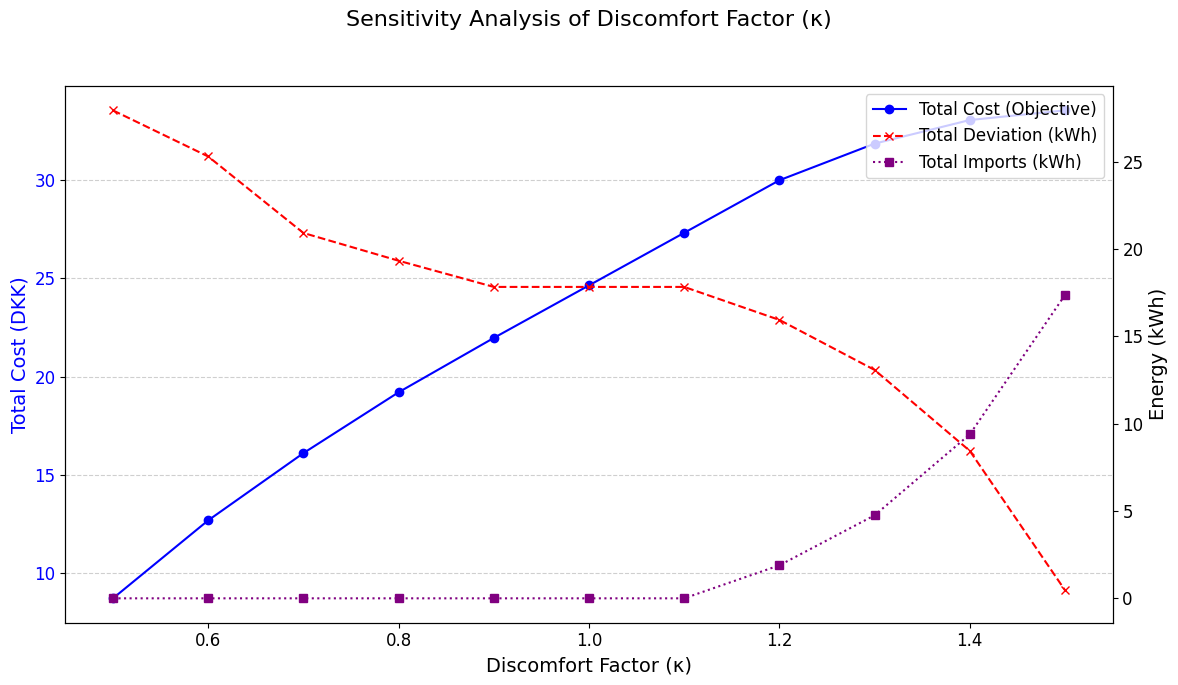

In [126]:
# --- SENSITIVITY ANALYSIS SETUP ---
# Define the range of kappa values to test
kappa_values = np.linspace(0.5, 1.5, 11) # 11 steps from 0.5 to 1.5
sensitivity_results = []

# Use the "Base" scenario for the analysis
sc = scenarios["Base"]

print(f"Running sensitivity analysis for kappa from {kappa_values.min()} to {kappa_values.max()}...")

# Loop through each kappa value
for kappa in kappa_values:
    # 1. Build input data with the current kappa
    input_data = build_input_data_1b(base, sc, kappa=kappa)
    
    # 2. Run optimization
    problem = LP_OptimizationProblem(input_data)
    problem.model.setParam('OutputFlag', 0) # Suppress Gurobi output for cleaner loop
    problem.run()
    
    # 3. Extract and store the key results
    if problem.model.status == GRB.OPTIMAL:
        df = results_to_dataframe(problem.results, base["T"])
        result_summary = {
            "kappa": kappa,
            "Objective": problem.results.objective_value,
            "Total Deviation": df["d+"].sum() + df["d-"].sum(),
            "Total Imports": df["e"].sum(),
            "Total Exports": df["s"].sum(),
            "Total PV Self-Consumed": df["p"].sum()
        }
        sensitivity_results.append(result_summary)

# Convert the list of results into a DataFrame for easy plotting
sensitivity_df = pd.DataFrame(sensitivity_results).set_index("kappa")

print("Analysis complete.")
# display(sensitivity_df)
plot_sensitivity_analysis(sensitivity_df)

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 96 rows, 168 columns and 240 nonzeros
Model fingerprint: 0x9a6cebe6
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 87 rows and 143 columns
Presolve time: 0.01s
Presolved: 9 rows, 25 columns, 27 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4152845e+01   9.345000e+00   0.000000e+00      0s
       7    3.1840845e+01   0.000000e+00   0.000000e+00      0s

Solved in 7 iterations and 0.02 seconds (0.00 work units)
Optimal objective  3.184084500e+01


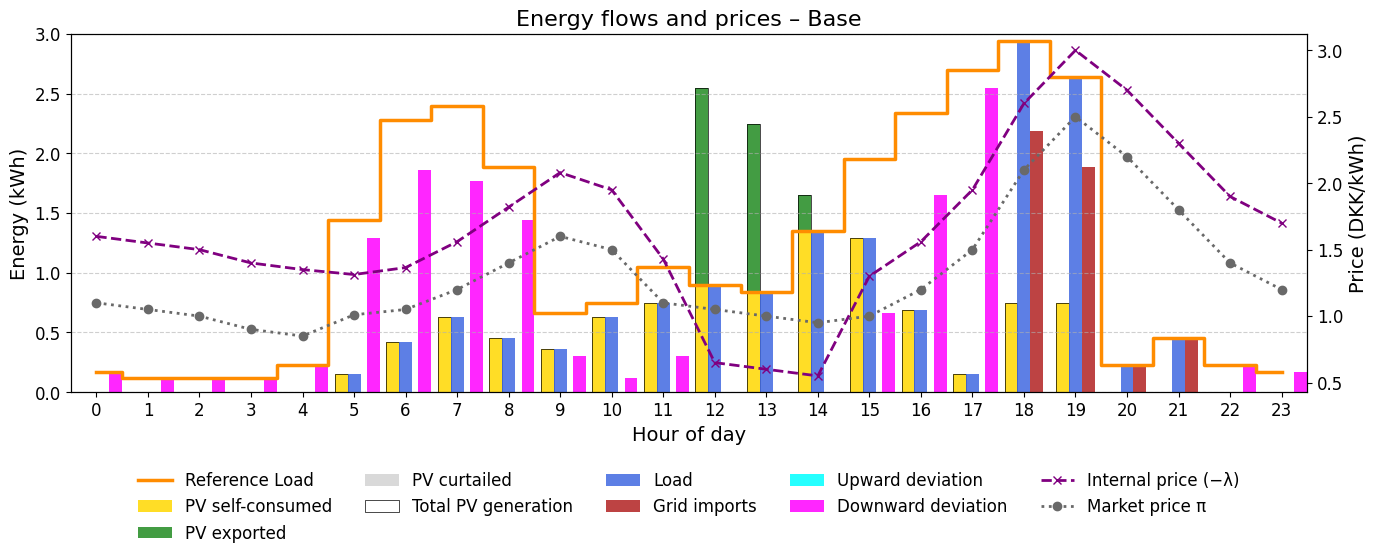

sum of load: 14.864999999999998


In [127]:
# --- Base scenario ---
scenario_name = "Base"
sc = scenarios[scenario_name]

# 1) Build input data
input_data = build_input_data_1b(base, sc)

# 2) Run optimization
problem = LP_OptimizationProblem(input_data)
problem.run()

# 3) Convert results to DataFrame
df = results_to_dataframe(problem.results, base["T"])

# 4) Extract duals (λ_t for hourly balance constraints)
duals_lambda = [problem.results.duals[f"constr[{i}]"] for i in range(base["T"])]
# ADVANCED: Extract the δ_t duals
num_constraints_before = 3 * base["T"] # (load balance + PV split + max load)
duals_delta = [problem.results.duals[f"constr[{i}]"] for i in range(num_constraints_before, num_constraints_before + base["T"])]

# 5) Plot
plot_hourly_flows_with_prices(
    df,
    scenario_name,
    duals=duals_lambda, # Use the correctly extracted duals
    price=sc["price"],
    alpha=sc["price"] + sc["imp"],
    beta=sc["price"] - sc["exp"],
    L_ref=base["L_ref"] 
)
print("sum of load:", df["l"].sum())

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 96 rows, 168 columns and 240 nonzeros
Model fingerprint: 0x7eb99eb6
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-01, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 93 rows and 159 columns
Presolve time: 0.00s
Presolved: 3 rows, 9 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4656914e+01   3.090000e+00   0.000000e+00      0s
       3    2.7497139e+01   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.749713875e+01


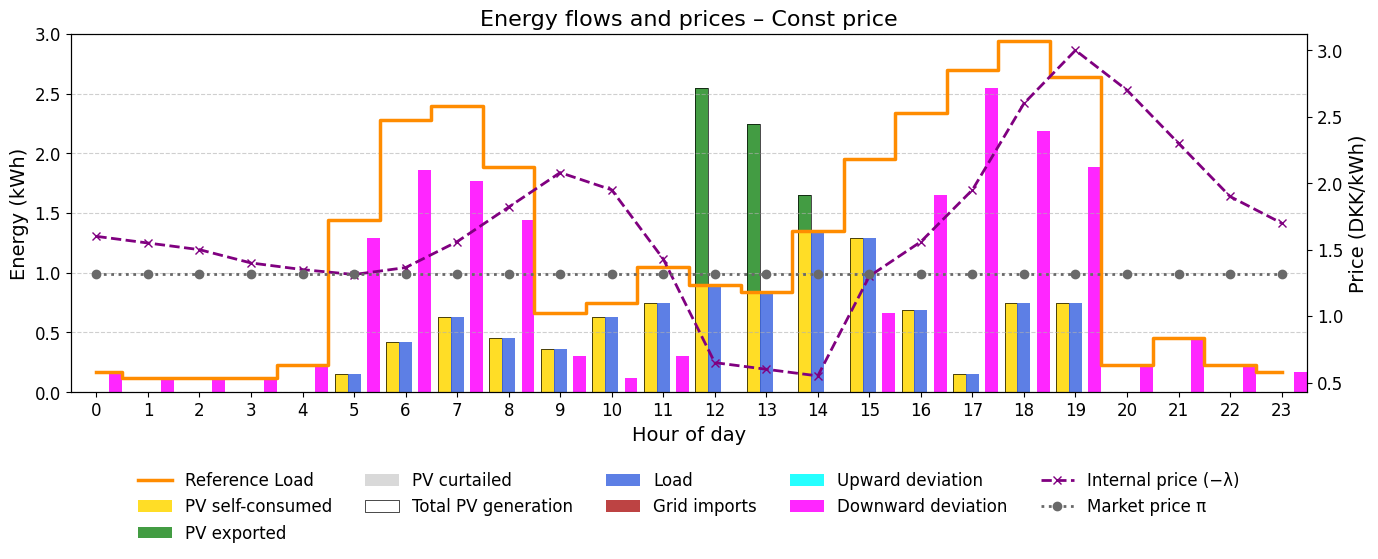

sum of load: 10.11
-1.8191666666666666
-1.7149166666666666


In [128]:
# --- Constant price scenario ---
scenario_name = "Const price"
sc = scenarios[scenario_name]

input_data = build_input_data_1b(base, sc)
problem = LP_OptimizationProblem(input_data)
problem.run()
df = results_to_dataframe(problem.results, base["T"])
duals = [problem.results.duals[f"constr[{i}]"] for i in range(base["T"])]

# Plot
plot_hourly_flows_with_prices(
    df,
    scenario_name,
    duals=duals_lambda, # Use the correctly extracted duals
    price=sc["price"],
    alpha=sc["price"] + sc["imp"],
    beta=sc["price"] - sc["exp"],
    L_ref=base["L_ref"] 
)

print("sum of load:", df["l"].sum())
print(problem.results.duals["constr[0]"])
print(problem.results.duals["constr[8]"])

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 96 rows, 168 columns and 240 nonzeros
Model fingerprint: 0x338968e6
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 72 rows and 96 columns
Presolve time: 0.00s
Presolved: 24 rows, 72 columns, 72 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6612500e+01   2.794500e+01   0.000000e+00      0s
      24    2.3292150e+01   0.000000e+00   0.000000e+00      0s

Solved in 24 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.329215000e+01


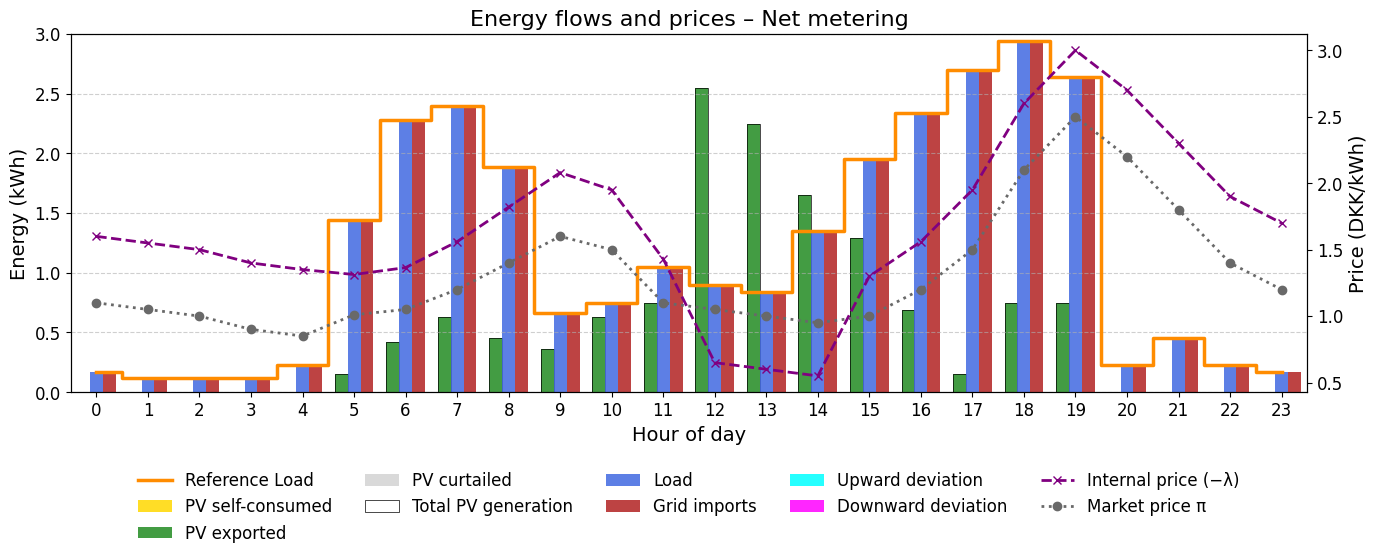

sum of load: 27.945


In [129]:
# --- Net metering scenario ---
scenario_name = "Net metering"
sc = scenarios[scenario_name]

input_data = build_input_data_1b(base, sc)
problem = LP_OptimizationProblem(input_data)
problem.run()
df = results_to_dataframe(problem.results, base["T"])
duals = [problem.results.duals[f"constr[{i}]"] for i in range(base["T"])]

# Plot
plot_hourly_flows_with_prices(
    df,
    scenario_name,
    duals=duals_lambda, # Use the correctly extracted duals
    price=sc["price"],
    alpha=sc["price"] + sc["imp"],
    beta=sc["price"] - sc["exp"],
    L_ref=base["L_ref"] 
)
print("sum of load:", df["l"].sum())

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))



CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 96 rows, 168 columns and 240 nonzeros
Model fingerprint: 0x1c2ac517
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 87 rows and 143 columns
Presolve time: 0.00s
Presolved: 9 rows, 25 columns, 27 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0917845e+01   4.755000e+00   0.000000e+00      0s
       4    3.3924345e+01   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.392434500e+01


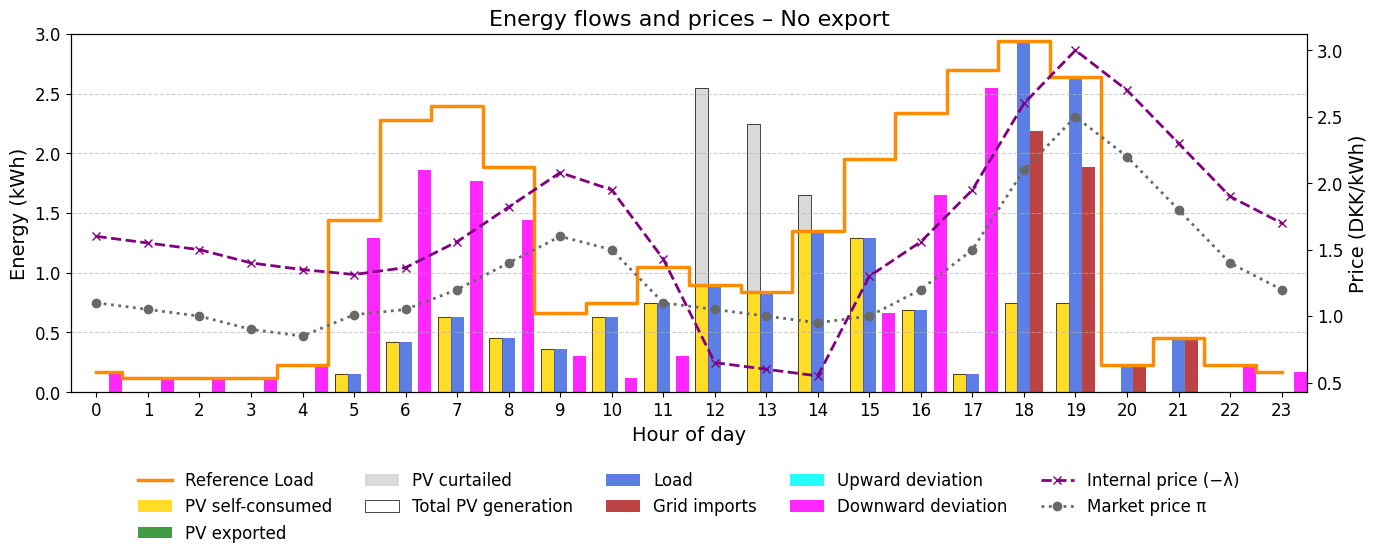

sum of load: 14.864999999999998


In [130]:
# --- No export scenario ---
scenario_name = "No export"
sc = scenarios[scenario_name]

input_data = build_input_data_1b(base, sc)
problem = LP_OptimizationProblem(input_data)
problem.run()
df = results_to_dataframe(problem.results, base["T"])
duals = [problem.results.duals[f"constr[{i}]"] for i in range(base["T"])]

# Plot
plot_hourly_flows_with_prices(
    df,
    scenario_name,
    duals=duals_lambda, # Use the correctly extracted duals
    price=sc["price"],
    alpha=sc["price"] + sc["imp"],
    beta=sc["price"] - sc["exp"],
    L_ref=base["L_ref"] 
)
print("sum of load:", df["l"].sum())

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 96 rows, 168 columns and 240 nonzeros


Model fingerprint: 0x25322874
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 7e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 87 rows and 143 columns
Presolve time: 0.00s
Presolved: 9 rows, 25 columns, 27 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0702845e+01   9.345000e+00   0.000000e+00      0s
       7    4.2469845e+01   0.000000e+00   0.000000e+00      0s

Solved in 7 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.246984500e+01


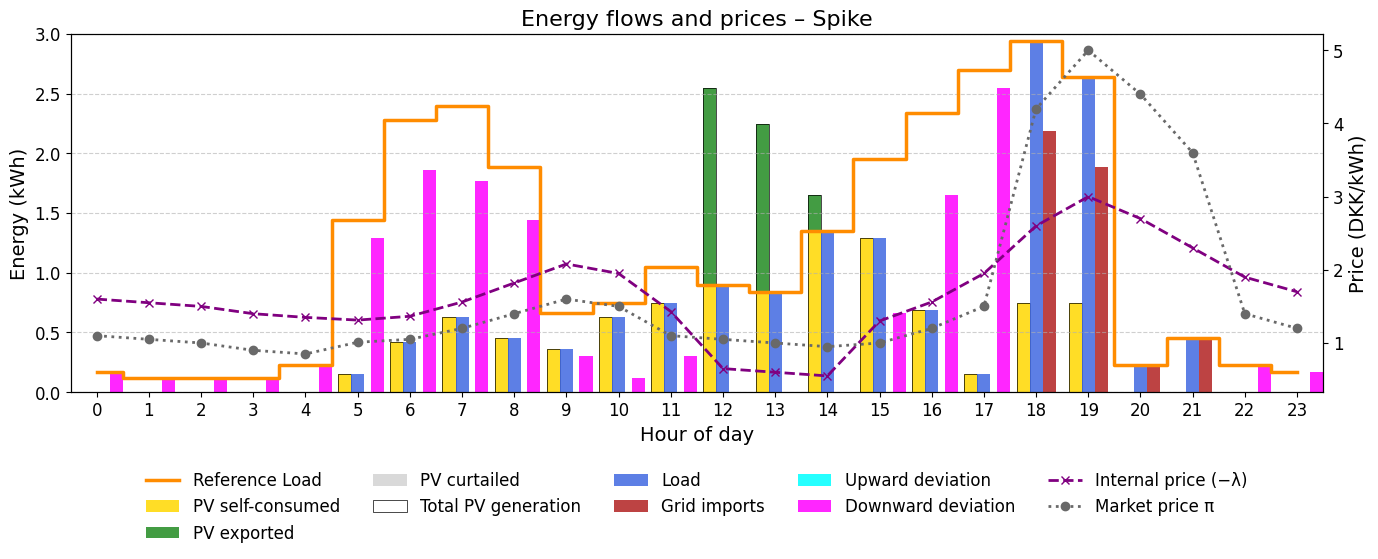

sum of load: 14.864999999999998


In [131]:
# --- Evening spike scenario ---
scenario_name = "Spike"
sc = scenarios[scenario_name]

input_data = build_input_data_1b(base, sc)
problem = LP_OptimizationProblem(input_data)
problem.run()
df = results_to_dataframe(problem.results, base["T"])
duals = [problem.results.duals[f"constr[{i}]"] for i in range(base["T"])]

# Plot
plot_hourly_flows_with_prices(
    df,
    scenario_name,
    duals=duals_lambda, # Use the correctly extracted duals
    price=sc["price"],
    alpha=sc["price"] + sc["imp"],
    beta=sc["price"] - sc["exp"],
    L_ref=base["L_ref"] 
)
print("sum of load:", df["l"].sum())

### Reporting

In [132]:
def plot_scenarios_subplots(scenario_results, titles, price_list, alpha_list, beta_list, duals_list, l_ref_list):

    fig, axes = plt.subplots(
        nrows=len(scenario_results), ncols=1,
        figsize=(14, 5*len(scenario_results)), sharex=True # Increased height slightly
    )

    if len(scenario_results) == 1:
        axes = [axes]

    # Added l_ref to the zip iterator
    for ax1, df, title, price, alpha, beta, duals, l_ref in zip(
        axes, scenario_results, titles, price_list, alpha_list, beta_list, duals_list, l_ref_list):

        # --- Rename and compute ---
        df_named = df.rename(columns={
            "l": "Load",
            "p": "PV self-consumed",
            "e": "Grid imports",
            "s": "PV exported",
            "c": "PV curtailed",
            "d+": "Upward deviation",
            "d-": "Downward deviation",
        })
        df_named["PV generation"] = (
            df_named["PV self-consumed"]
            + df_named["PV exported"]
            + df_named["PV curtailed"]
        )

        hours = df_named.index
        # Adjusted width to make space for more bars
        width = 0.2
        bar_alpha = 0.85

        # Adjusted bar positions for new layout
        # --- PV generation bars (left-most) ---
        ax1.bar(hours - 1.5*width, df_named["PV self-consumed"], width,
                label="PV self-consumed", color="gold", alpha=bar_alpha)
        ax1.bar(hours - 1.5*width, df_named["PV exported"], width,
                bottom=df_named["PV self-consumed"], label="PV exported", color="forestgreen", alpha=bar_alpha)
        ax1.bar(hours - 1.5*width, df_named["PV curtailed"], width,
                bottom=df_named["PV self-consumed"]+df_named["PV exported"], label="PV curtailed", color="lightgray", alpha=bar_alpha)
        ax1.bar(hours - 1.5*width, df_named["PV generation"], width,
                fill=False, edgecolor="black", linewidth=0.5, label="Total PV generation")

        # --- Load (center-left) ---
        ax1.bar(hours - 0.5*width, df_named["Load"], width, label="Load", color="royalblue", alpha=bar_alpha)

        # --- Imports (center-right) ---
        ax1.bar(hours + 0.5*width, df_named["Grid imports"], width, label="Grid imports", color="firebrick", alpha=bar_alpha)

        # --- Deviation bars (right-most, stacked) ---
        ax1.bar(hours + 1.5*width, df_named["Upward deviation"], width, 
                label="Upward deviation", color="cyan", alpha=bar_alpha)
        ax1.bar(hours + 1.5*width, df_named["Downward deviation"], width,
                bottom=df_named["Upward deviation"], label="Downward deviation", color="magenta", alpha=bar_alpha)

        # --- Reference Load Line ---
        ax1.plot(hours, l_ref, color='darkorange', linestyle='-', drawstyle='steps-mid',
                 linewidth=2.5, label='Reference Load')
        
        # --- Axis and Title ---
        ax1.set_title(title)
        ax1.set_ylabel("Energy (kWh)")
        
        # ... (rest of axis formatting is the same) ...
        if "Net metering" in title:
            ax1.set_ylim(0, 9)
        else:
            ax1.set_ylim(0, 4) # Increased ylim slightly to see L_ref better

        # --- Prices (secondary axis) ---
        ax2 = ax1.twinx()
        p_int = [-d for d in duals] # Flip sign for positive internal price
        ax2.plot(hours, p_int, marker="x", linestyle="--", color="purple", linewidth=2, label="Internal price (λ)")
        
        # Market price is now red
        ax2.plot(hours, price, marker="o", linestyle=":", color="red", linewidth=2, label="Market price π")

        ax2.set_ylabel("Price (DKK/kWh)")
        ax2.set_ylim(-0.5, 3.5) # Adjusted ylim for prices
        ax1.right_ax = ax2
    
    handles1, labels1 = axes[0].get_legend_handles_labels()
    handles2, labels2 = axes[0].right_ax.get_legend_handles_labels()

    # Create a dictionary to remove duplicate labels from legend
    legend_dict = dict(zip(labels1 + labels2, handles1 + handles2))
    
    fig.legend(legend_dict.values(), legend_dict.keys(),
               loc="lower center", bbox_to_anchor=(0.5, 0.01),
               ncol=6, frameon=False)

    plt.tight_layout(rect=[0, 0.08, 1, 1]) # Adjust rect to give legend more space
    plt.show()

In [135]:
scenario_names = ["Base", "Const price", "Net metering", "No export"]

# Added l_ref_list for the new plot function
dfs, duals_list, price_list, alpha_list, beta_list = [], [], [], [], []
l_ref_list = [] # Will be the same for all scenarios, but we build a list
results_summary = {}

for scenario_name in scenario_names:
    sc = scenarios[scenario_name]
    # This should call your new function for 1b
    input_data = build_input_data_1b(base, sc)
    problem = LP_OptimizationProblem(input_data)
    problem.run()
    
    # Store primal results
    df = results_to_dataframe(problem.results, base["T"])
    dfs.append(df)
    
    # Correctly store λ duals (now constr[0] to constr[T-1])
    lambdas = [problem.results.duals[f"constr[{i}]"] for i in range(base["T"])]
    duals_list.append(lambdas)
    
    # Prices (this part is unchanged)
    price_list.append(sc["price"])
    alpha_list.append(sc["price"] + sc["imp"])
    beta_list.append(sc["price"] - sc["exp"])
    
    # Add the L_ref to its list for plotting
    l_ref_list.append(base["L_ref"])
    
    # Extract duals based on the new constraint order for the summary table
    T = base["T"]
    # mu is gone. lambdas are already extracted above.
    rhos = [problem.results.duals[f"constr[{i}]"] for i in range(T, 2*T)]
    nus = [problem.results.duals[f"constr[{i}]"] for i in range(2*T, 3*T)]
    deltas = [problem.results.duals[f"constr[{i}]"] for i in range(3*T, 4*T)]

    # Update the summary dictionary for the new model
    results_summary[scenario_name] = {
        "Objective": problem.results.objective_value,
        "Total import": df["e"].sum(),
        "Total export": df["s"].sum(),
        "Total curtailed": df["c"].sum(),
        "Total load": df["l"].sum(),
        # NEW: Summarize deviation variables
        "Total upward dev": df["d+"].sum(),
        "Total downward dev": df["d-"].sum(),
        # mu is removed
        "lambda_mean": np.mean(lambdas),
        "rho_mean": np.mean(rhos),
        # NEW: Summarize new duals
        "delta_mean": np.mean(deltas),
        "nu_mean": np.mean(nus),
    }

# Convert results to DataFrame for later export
df_results = pd.DataFrame(results_summary).T

# Print LaTeX table
print(df_results.to_latex(float_format="%.2f", caption="Primal and dual results by scenario", label="tab:results"))

# Call the updated plot function with the new l_ref_list argument
plot_scenarios_subplots(dfs, scenario_names, price_list, alpha_list, beta_list, duals_list, l_ref_list)

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 96 rows, 168 columns and 240 nonzeros
Model fingerprint: 0x9a6cebe6
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 87 rows and 143 columns
Presolve time: 0.01s
Presolved: 9 rows, 25 columns, 27 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4152845e+01   9.345000e+00   0.000000e+00      0s
       7    3.1840845e+01   0.000000e+00   0.000000e+00      0s

Solved in 7 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.184084500e+01
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th G

ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

In [ ]:
df_results

,Objective,Total import,Total export,Total curtailed,Total load,Total upward dev,Total downward dev,lambda_mean,rho_mean,delta_mean,nu_mean
Base,31.840845,4.755,3.36,0.00,14.865,0.0,13.080,-1.655333,-1.655333,1.603250,0.0
Const price,27.497139,0.000,3.36,0.00,10.110,0.0,17.835,-1.654542,-1.654542,1.615448,0.0
Net metering,23.292150,27.945,13.47,0.00,27.945,0.0,0.000,-1.319167,-1.319167,1.319167,0.0
No export,33.924345,4.755,0.00,3.36,14.865,0.0,13.080,-1.580333,-1.580333,1.528250,0.0
